# Wi-Fiパケットデータによる交通分析（飯田通りを例に）


- 甲府市におけるWi-Fiパケット観測の一端を知る。（地点間流動データの可視化例をもとに）
- Wi-Fiパケットデータをもとに飯田通りを例に移動時間分布を調べてみる。
- Google Traffic Info. のデータとの比較を行ってみる。

データは、研究室サーバ 8tops.yamanashi.ac.jp上にある。データの形式はGoogle Driveの2019年フォルダにある「Wi-Fiデータ処理・形式」というメモを参照のこと。


## 2地点間流動の図示

図示したい地点ペアと集計範囲の年月日を指定して作図する関数(plot_hourly_flow)を定義し、実行するサンプルを以下に示す。

### 描画関数定義

In [1]:
# 流動プロット用関数定義
# データはデータベースに格納されている

# DB接続
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

font_size =24
fig_size = (14,8)

# 8tops上でのファイル (ファイル名は環境に応じて変更すること)
conn = sqlite3.connect("/home/raspimngr/db/kofu_traveler.sqlite3")
#conn = sqlite3.connect("kofu_traveler.sqlite3")
cur = conn.cursor()

# テーブル名 (flow, flow_trunc10, flow_all_trunc, flow_all, flow_all_trunc10のどれか)
table_name = "flow_all_trunc10"


# 時間帯別流動数

def plot_hourly_flow(path, sub_title="", filename_body="temp", image_type="", direction=False,
                     sdate="2019-09-01", edate="2019-12-31", legend_outside=False):
    count_data = {"00": {}, "01":{},"02": {},"03": {},"04": {},"05": {},"06": {},"07": {},"08": {},"09": {},
                 "10": {},"11": {},"12": {},"13": {},"14": {},"15": {},"16": {},"17": {},"18": {},"19": {},
                 "20": {},"21": {},"22": {},"23": {}}
    opt_direction = ""
    for l, pos in path.items():
        if direction:
            opt_direction = ''
        else:
            opt_direction = ' or (origin="' + pos[1] + '" and destination="' + pos[0] + '")'
        
        sql = ("select hour, sum(number) from " + table_name 
               + ' where ((origin="' + pos[0] + '" and destination="' + pos[1] + '")'
               + opt_direction + ")"
               + ' and yearday>="' + sdate + '" and yearday<="' + edate+'" '
               + ' group by hour order by hour')
        result = cur.execute(sql).fetchall()
        for v in result:
            count_data[v[0]][l] = v[1]
    df = pd.DataFrame.from_dict(count_data)
    df = df.T
    df = df.reset_index()
    
    fig = plt.figure( figsize=fig_size)
    ax = fig.add_subplot(1, 1, 1)
    ax = df.plot(ax=ax, fontsize=font_size, xticks=df.index, lw=4)
    if legend_outside:
        ax.legend(fontsize=font_size,loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        ax.legend(fontsize=font_size)
    ax.set_title("時間別移動アドレス数"+sub_title + "  "+ sdate + " ～ " + edate, fontsize=font_size)
    ax.set_xlabel("時間", fontsize=font_size)
    ax.set_ylabel("アドレス数", fontsize=font_size)
    
    if image_type !="":
        if image_type=="emf": # 出力形式がemf指定のときは、svgにセーブしてからinkscapeで変換
            plt.savefig(filename_body + ".svg" , bbox_inches="tight")
            import subprocess
            subprocess.run("inkscape --file " + filename_body + ".svg"
                           + " --export-emf " + filename_body + ".emf", shell=True)
        else:
            plt.savefig(filename_body + "." + image_type, bbox_inches="tight")
    plt.show()
                     
def get_name_pairs(point_pairs, area="kofu"):
    """
    [["12","22"], [ ], ... のような地点ペアを与えて、地点名をキーに入れて返す
    """
    filename = {"kofu": "/var/www/html/kofu/sensor_points.csv",
            "fuefuki": "/var/www/html/ff/sensor_points.csv",
            "hakushu": "/var/www/html/hakushu/sensor_points.csv",
            "ttri": "/home/toyotamngr/csv/toyota/sensor_points.csv"}
    
    df = pd.read_csv(filename[area])
    path = {}
    
    for p in  point_pairs:
        if area == "kofu":
            p0 = "kofu" + p[0]
            p1 = "kofu" + p[1]
        else:
            p0 = p[0]
            p1 = p[1]
        key = (df[df.センサ名 == p0]['短縮名'].values[0] + " - "
               + df[df.センサ名 == p1]['短縮名'].values[0])
        path[key] = [p[0], p[1]]
    return path

### 実行例

地点（センサ）番号の一覧は附録に示す通り。


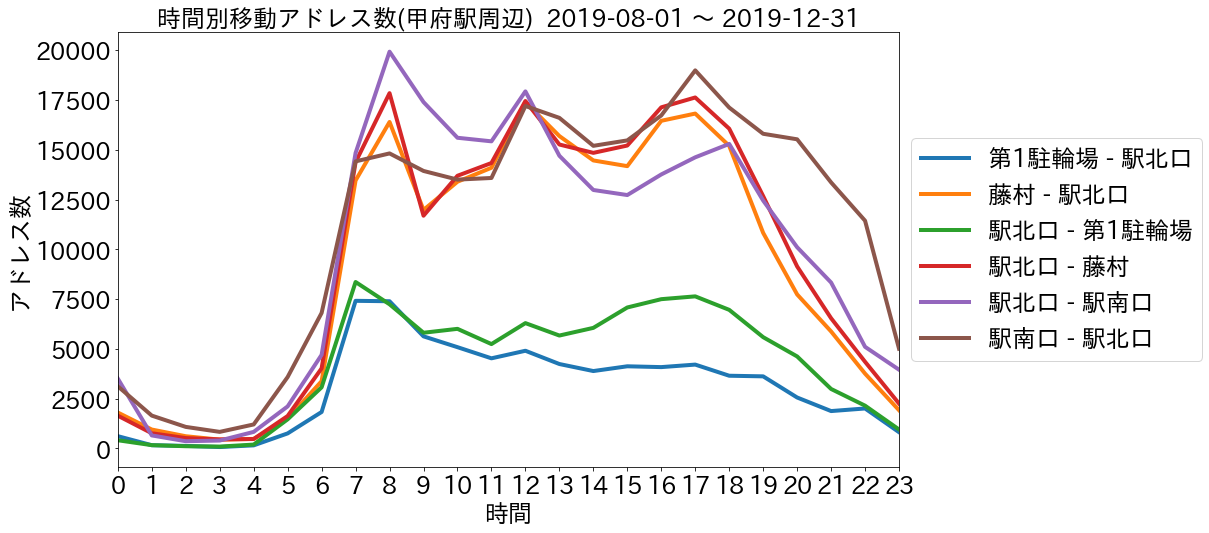

In [2]:
# 実行サンプル
# 駅南北
pairs = [["26", "27"], ["27", "26"], ["27", "28"], ["28","27"],["25","27"],["27", '25']] # 調べたい地点ペア
path = get_name_pairs(pairs)
plot_hourly_flow(path, "(甲府駅周辺)","KofuStationFlow", "emf", sdate="2019-08-01", edate="2019-12-31",
                 direction=True, legend_outside=True)

## 所要時間分布のヒストグラム作成例

城東通りを例にした移動時間分布


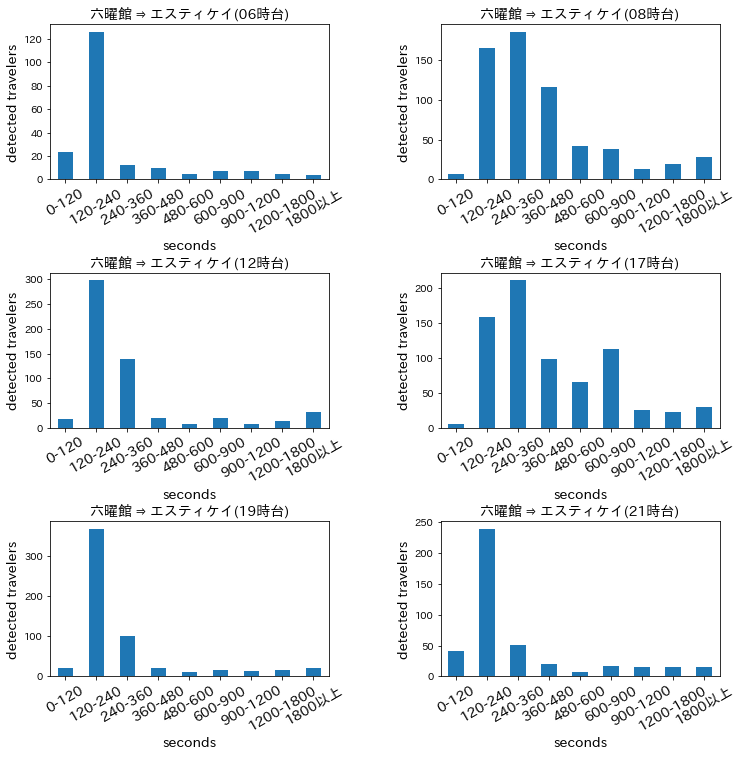

In [4]:
# 所要時間ヒストグラムを作る関数定義
# DBへの接続手続きを最初に行う
# DBに格納されている観測開始日を、DBへの問い合わせSQLに埋め込み (dDateで)
# DB接続
import sqlite3
db_file = "/home/raspimngr/db/kofu_traveler.sqlite3" # ファイルの場所はそれぞれの環境に応じて変える
conn = sqlite3.connect(db_file)
# 8tops上のDBファイル (2019/03時点)
conn = sqlite3.connect("/home/raspimngr/db/kofu_traveler.sqlite3")
cur = conn.cursor()

def query(sql_str):
    cur.execute(sql_str)
    return cur.fetchall()

#####以上、DB接続######################

import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline


def showTravelTimeHistgram(origin, destination, hour_list,
                          bin_list = [0, 120, 240, 360, 480, 600, 900, 1200, 1800, 3600] # 区分(秒)
                          ):
    sql = ("select strftime('%H',dTime), aTime, dTime from traveler_all " +
           "where dDate>='2019-10-20' " + " and origin='" + origin +
           "' and destination='" + destination + "' and glbit=0")
    result = query(sql)
    raw_data = {}
    hour = hour_list #  知りたい時間
    for i in range(24):
        raw_data[str(i).zfill(2)] = []
    
    for d in result:
        sec = (datetime.strptime(d[1], "%H:%M:%S") - datetime.strptime(
            d[2], "%H:%M:%S")).total_seconds()
        if sec < 10:
            continue
        raw_data[d[0]].append([d[1], d[2], sec])
    # print(raw_data)

    # 区分(値の区切り)
    # ラベルを自動生成 (最後の値は多めにとってあるので、「以上」と記す)
    bin_label = [str(bin_list[i])+"-"+str(bin_list[i+1]) for i in range(len(bin_list)-2)]
    bin_label.append(str(bin_list[-2])+"以上")
    
    hist_data = {}
    # pandas DataFrame形式のデータ作成
    for n, h in enumerate(hour):
        # 時刻hのデータをDataFrame形式に
        df_raw = pd.DataFrame(
            raw_data[h], columns=["departure_time", "arrival_time", "travel_time"])
        # bin_listで指定した区分のヒストグラムデータに
        hist_data[n] = pd.cut(
            df_raw["travel_time"], bins=bin_list, labels=bin_label,
            right=False).value_counts(sort=False)

    # センサー設置場所の名前取得    
    result = cur.execute("select * from sensor").fetchall()
    sensor = {}
    for v in result:
        sensor[v[0]] = {'name': v[3], 'shortname': v[5], 'area': v[4]}

    # 描画
    fig_num_rows = int(len(hour) / 2)
    fig = plt.figure(figsize=(12, 4 * fig_num_rows))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    
    ax = []
    for n, h in enumerate(hour):
        ax.append(fig.add_subplot(fig_num_rows, 2, n + 1))
        hist_data[n].plot.bar(ax=ax[n])
        ax[n].set_title(sensor[origin]["shortname"]
                        + " ⇒ " + sensor[destination]["shortname"]
                        + "(" + h + "時台)", fontsize=14)
        ax[n].set_xlabel("seconds", fontsize=14)
        ax[n].set_ylabel("detected travelers", fontsize=14)
        ax[n].xaxis.set_tick_params(rotation=30, labelsize=14) 
    
    # plt.savefig("flow_bousai_dan.svg")
    plt.show()
    
#### main ###
#六曜館(23)とエスケイティ(32)間を移動した人の出発時刻と到着時刻の抽出
origin = "23"
destination = "32"
hour_list = ["06", "08", "12", "17", "19", "21"] # 調べたい時間帯
showTravelTimeHistgram(origin, destination, hour_list)

## Google traffic info

GoobleのAPIを通じて得られる2地点間の車での所要時間を取得する。

方法（プログラム）については、

https://toyoki-lab.ee.yamanashi.ac.jp/~toyoki/labTips/UseGoogleAPI.html

に書いてある通り。

2019/12/05より、平和通り県庁前交差点から甲府気象台東（飯田通りとアルプス通りの交差点）の所要時間を記録している。

つぎのようにしてみることができる。


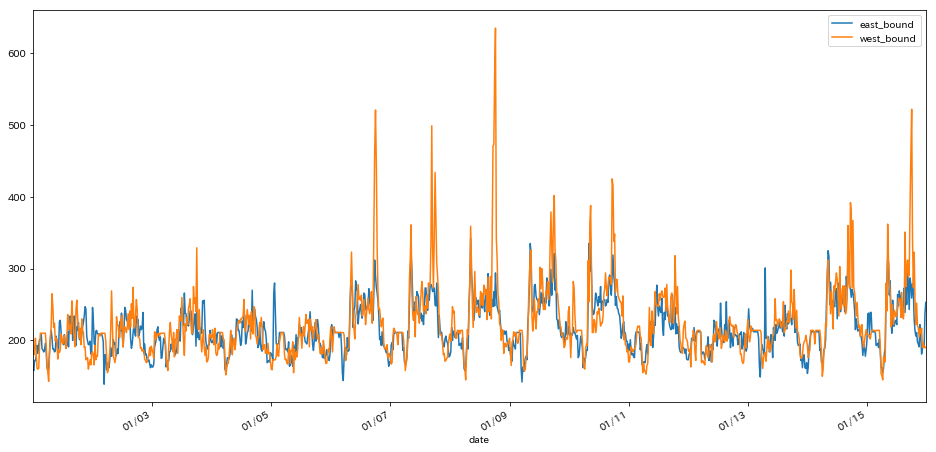

In [30]:
# 8tops上で採取しているデータの閲覧
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter # 時間軸のフォーマットを自在に
from datetime import datetime

fig, ax = plt.subplots(figsize=(8, 4))

df = pd.read_csv("/ssd/toyoki/googleData/iida/iidaBothTrafficByGoogle.csv",sep=",",skipinitialspace=True)
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M:%S')
df_part = df[(datetime(2020,1,1) < df['date']) & (df['date'] < datetime(2020,1,16))]
df_part.plot(x='date', y=['east_bound','west_bound'], figsize=(16,8), ax=ax)
ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))

日々のデータを平均して、1日の時間変化をみるスクリプトは、城東通りの分析例を参考にする。（もちろん、自分で考えてみるのがよい。）

## 付録

センサ一覧

In [3]:
import pandas as pd
filename = {"kofu": "/var/www/html/kofu/sensor_points.csv",
            "fuefuki": "/var/www/html/ff/sensor_points.csv",
            "hakushu": "/var/www/html/hakushu/sensor_points.csv",
            "ttri": "/home/toyotamngr/csv/toyota/sensor_points.csv"}
pd.read_csv(filename["kofu"])

センサ名        lat         log              地点名    カテゴリ       短縮名
0    kofu1        NaN         NaN              NaN     NaN       NaN
1    kofu2  35.658933  138.571024             三枝豆店      中央      三枝豆店
2    kofu3  35.660988  138.571165              風月堂      中央       風月堂
3    kofu4  35.670632  138.565893             永田楽器  北口・朝日町      永田楽器
4    kofu5  35.662019  138.571818   文化のるつぼ Hechima     丸の内       るつぼ
5    kofu6        NaN         NaN              NaN     NaN       NaN
6    kofu7  35.666474  138.567104        ライフインナカゴミ     丸の内     ライフイン
7    kofu8  35.669087  138.566179       オスカー本社・朝日店  北口・朝日町      オスカー
8    kofu9  35.663483  138.568223           防災新館1F     丸の内      防災新館
9   kofu10  35.660508  138.571015           河野スポーツ      中央        河野
10  kofu11  35.658980  138.569654       内藤セイビドー眼鏡店      中央   内藤セイビドー
11  kofu12  35.665457  138.567812        立ち食い焼肉 鷹の     丸の内        鷹の
12  kofu13  35.659908  138.571535   銀座通り東（ブラザー文房具）      中央     銀座通り東
13  kofu14  35.666835  138.571457            甲州夢小路  北口・朝日町       夢小路
14  kofu15        NaN         NaN              NaN     NaN       NaN
15  kofu16  35.662705  138.570433         甲府クラフトラボ     丸の内    クラフトラボ
16  kofu17  35.661394  138.568810            ダン珈琲店      中央        ダン
17  kofu18  35.662433  138.569498       カフェ・キュイエール     丸の内    キュイエール
18  kofu19  35.660883  138.570182              きぬや      中央       きぬや
19  kofu20  35.660050  138.569150           そば処 奥義      中央        奥義
20  kofu21  35.671693  138.566729               玉屋  北口・朝日町        玉屋
21  kofu22  35.665733  138.568327             奥藤本店     丸の内        奥籐
22  kofu23  35.665305  138.567282        六曜館珈琲店 本店     丸の内       六曜館
23  kofu24  35.660092  138.570098  銀座通り東（ルパンザバール前）      中央     銀座通り西
24  kofu25  35.666321  138.568691            甲府駅南口   甲府駅周辺       駅南口
25  kofu26  35.667769  138.570091            藤村記念館   甲府駅周辺        藤村
26  kofu27  35.667481  138.569165       甲府駅北口コンコース   甲府駅周辺       駅北口
27  kofu28  35.666682  138.567703       甲府駅南口第１駐輪場   甲府駅周辺     第1駐輪場
28  kofu29  35.666348  138.570488       甲府駅南口第２駐輪場   甲府駅周辺     第2駐輪場
29  kofu30  35.658877  138.569747         オリンピック通り      中央  オリンピック通り
30  kofu31  35.657720  138.569734          甲府商工会義所      中央     商工会議所
31  kofu32  35.668393  138.555370           エスティケイ      飯田    エスティケイ